## 1.构建网络 初探

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

### 1.1构建模型

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)#单通道、输出通道（叠几层）、卷积核大小
        self.fc1 = nn.Linear(1350, 10)#in, out
    
    def forward(self, x):
        #x: [1,1,32,32]
        x = self.conv1(x) #[1,6,30,30]
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2)) #池化过程不用重叠[1,6,15,15]
        x = F.relu(x)
        x = x.view(x.size()[0], -1) #压到[1,1350]
        x = self.fc1(x)
        return x
    
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1350, out_features=10, bias=True)
)

### 1.2查看模型

模型的参数值，shape，grad

In [21]:
print(model.conv1, '\n')
print(model.conv1.weight.shape) 
print(model.conv1.bias.shape)
model.conv1.bias.grad

Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1)) 

torch.Size([6, 1, 3, 3])
torch.Size([6])


tensor([ 1.2537,  0.0000,  0.1860,  0.0000, -0.6709,  0.8827])

In [23]:
print(model.fc1, '\n')
print(model.fc1.weight.shape) 
print(model.fc1.bias.shape)

Linear(in_features=1350, out_features=10, bias=True) 

torch.Size([10, 1350])
torch.Size([10])


查看所有parameters

In [3]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 0.2295, -0.2769,  0.1879],
          [-0.2160,  0.1160, -0.2031],
          [ 0.1784,  0.1745, -0.2437]]],


        [[[ 0.0662, -0.3169, -0.2802],
          [ 0.1660, -0.0944, -0.1504],
          [-0.1538, -0.3028,  0.0973]]],


        [[[ 0.0037,  0.2246,  0.1134],
          [-0.3086, -0.3174,  0.2631],
          [ 0.0581,  0.1560,  0.0604]]],


        [[[ 0.2531, -0.0741, -0.2685],
          [-0.1918, -0.2093,  0.0591],
          [-0.0220,  0.1060,  0.0461]]],


        [[[ 0.2819,  0.2070, -0.3130],
          [ 0.2241,  0.1345, -0.2879],
          [ 0.1541,  0.0086,  0.3181]]],


        [[[-0.1663, -0.0152,  0.2770],
          [-0.2049,  0.2131, -0.2883],
          [ 0.0913, -0.0793, -0.0869]]]], requires_grad=True)
Parameter containing:
tensor([ 0.2182, -0.0834,  0.0735, -0.2827,  0.1928,  0.0721],
       requires_grad=True)
Parameter containing:
tensor([[-0.0009,  0.0145, -0.0236,  ..., -0.0229,  0.0258, -0.0006],
        [ 0.0001,  0.0154, -0

In [4]:
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())

conv1.weight : torch.Size([6, 1, 3, 3])
conv1.bias : torch.Size([6])
fc1.weight : torch.Size([10, 1350])
fc1.bias : torch.Size([10])


### 1.3BP

In [5]:
x = torch.rand(1,1,32,32)
y_pred = model(x)
y_pred.size()

torch.Size([1, 10])

In [6]:
model.zero_grad()

# y_pred.backward(torch.ones(y_pred.shape)) #传1进去，才能对向量backward

# 但是其实y_pred本身进行BP没意义，我们要的是loss来BP
# 或者 y_pred.mean().backward()

In [7]:
y_label = torch.arange(0,10).view(1,10).float()
loss_fn = nn.MSELoss()
loss = loss_fn(y_label, y_pred)
loss

tensor(28.7616, grad_fn=<MeanBackward0>)

In [8]:
optim = torch.optim.SGD(model.parameters(), lr=0.001)
optim.zero_grad()
loss.backward()
optim.step()

## 2.实战：图像分类器
五个步骤：
1. Load and normalizing the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

In [9]:
import torch
import torchvision #包含图像数据的加载、变形扥操作
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

### 1.加载数据

In [37]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#什么意思？

trainset = torchvision.datasets.CIFAR10(root='./dataset',train=True,
                                       download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                       download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=5,
                        shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=5,
                        shuffle=True, num_workers=0)

classes = ['plane', 'car', 'bird', 'cat','deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


#### 可视化

torch.Size([5, 3, 32, 32]) torch.Size([5])
(3, 36, 172)
(36, 172, 3)


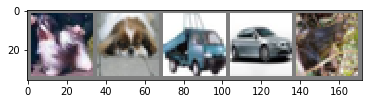

dog dog truck car frog


In [42]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img/2+0.5 
    # 因为Compose做了Normalize，这里需要unnormalize 去正态分布，不然会有负值
    
    npimg = img.numpy()
    print(npimg.shape, np.transpose(npimg,(1,2,0)).shape, sep='\n')
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

#随机获取一个batch的图片数据
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

#show
imshow(torchvision.utils.make_grid(images)) #变成网格，会自动加上margin，所以宽变成了32+2*2，长变成32*5+6*2
print(' '.join(classes[labels[i]] for i in range(5)))


### 2.构建CNN网络

In [39]:
import torch.nn as nn
import torch.nn.functional as F

In [58]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5,
                              stride=1, padding=0,)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, 
                                 padding=0)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # x:[b,c,h,w] 即[5,3,32,32]
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x))) #[4,6,28,28] 池化-->[4,6,14,14]
        x = self.pool(F.relu(self.conv2(x))) #[4,16,10,10] -->[4,16,5,5]
        x = x.view(-1, 16*5*5) #[4,400]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = CNN()
net

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 3.优化器

In [14]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4.训练网络

In [59]:
for epoch in range(1):
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i%1000 == 0:
            print('epoch:',epoch+1, 'iter:',i, 'loss:',loss.item())

epoch: 1 iter: 0 loss: 2.281451940536499
epoch: 1 iter: 1000 loss: 2.265282392501831
epoch: 1 iter: 2000 loss: 2.2763607501983643
epoch: 1 iter: 3000 loss: 2.3124327659606934
epoch: 1 iter: 4000 loss: 2.2853074073791504
epoch: 1 iter: 5000 loss: 2.326103687286377
epoch: 1 iter: 6000 loss: 2.297868251800537
epoch: 1 iter: 7000 loss: 2.308518886566162
epoch: 1 iter: 8000 loss: 2.315901517868042
epoch: 1 iter: 9000 loss: 2.2635443210601807


#### 保存模型

In [64]:
model_path = './models/CNN.pth'
torch.save(net.state_dict(), model_path)

In [57]:
for epoch in range(1):
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()

        opt.step()
        
        if i%1000 == 0:
            print('epoch:',epoch+1, 'iter:',i, 'loss:',loss.item())

epoch: 1 iter: 0 loss: 2.2837564945220947
epoch: 1 iter: 1000 loss: 2.3364531993865967
epoch: 1 iter: 2000 loss: 2.3116683959960938
epoch: 1 iter: 3000 loss: 2.296515703201294
epoch: 1 iter: 4000 loss: 2.2772839069366455
epoch: 1 iter: 5000 loss: 2.346975326538086
epoch: 1 iter: 6000 loss: 2.2442574501037598
epoch: 1 iter: 7000 loss: 2.289708375930786
epoch: 1 iter: 8000 loss: 2.302560329437256
epoch: 1 iter: 9000 loss: 2.279092311859131


### 5.测试模型

In [65]:
net.load_state_dict(torch.load(model_path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [68]:
outputs = net(images)
outputs.shape

torch.Size([5, 10])

In [33]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)#返回value, index
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct/total)

0.66302


In [31]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %s:'%classes[i], class_correct[i] / class_total[i])

Accuracy of plane: 0.8072
Accuracy of car: 0.7376
Accuracy of bird: 0.5044
Accuracy of cat: 0.4462
Accuracy of deer: 0.5196
Accuracy of dog: 0.6052
Accuracy of frog: 0.8576
Accuracy of horse: 0.7208
Accuracy of ship: 0.712
Accuracy of truck: 0.7196


In [30]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %s:'%classes[i], class_correct[i] / class_total[i])

Accuracy of plane: 0.796
Accuracy of car: 0.676
Accuracy of bird: 0.414
Accuracy of cat: 0.409
Accuracy of deer: 0.417
Accuracy of dog: 0.563
Accuracy of frog: 0.835
Accuracy of horse: 0.661
Accuracy of ship: 0.651
Accuracy of truck: 0.655
